# Main file for calibration #

### Chiara Masia
### Summer student program 2024
any questions or suggestions chiara.masia01@gmail.com

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import function as f
from scipy.signal import find_peaks
from NewCalibration import Calib_position
from NewCalibration import Calib_energy
from NewCalibration import Calib_channel


work_dir = os.getcwd()
chipnumber = 'sparechip04' # analyzed chip 

### Balistic calibration ###

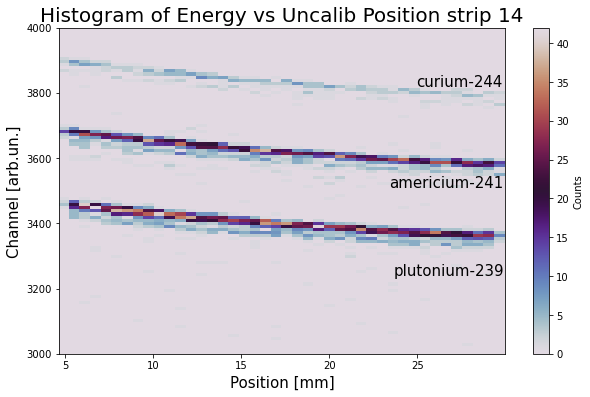

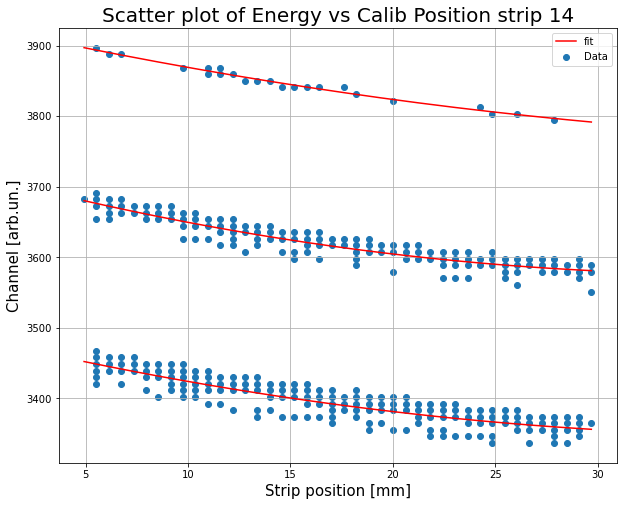

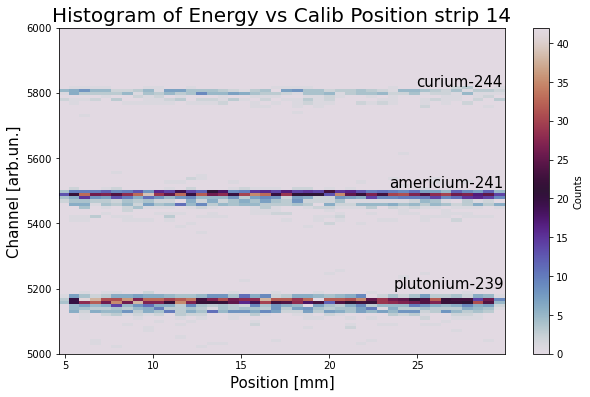

In [2]:

# this part handles the balistic calibration

lower_bound = [3500, 3400, 3500, 3500, 3500, 3500, 3450, 3400, 3450, 3450, 3500, 3500, 3600, 3500, 3500] # seen from plot_data
upper_bound = [3750, 3700, 3700, 3700, 3700, 3700, 3700, 3650, 3800, 3750, 3700, 3800, 3800, 3750, 3700]

# tabulated energies of the alpha particles

energy1 = 5156.59 
energy2 = 5485.46
energy3 = 5804.77


thres= [20, 20, 20, 20, 20, 15, 20, 15, 15, 30, 15, 15, 15, 10, 15, 20] # threshold for selecting relevant counts


for ii in range(14,15):
    file = "20240826_sparechip04_uncalib.txt"
    strip = ii
    my_cal = Calib_position("Strippos", "Energy")
    my_cal.read_data(file)
    my_cal.plot_hist(strip)
    my_cal.plot_data(strip, 5)
    my_cal.fit_data(strip, lower_bound[ii-1], upper_bound[ii-1]) 
    #my_cal.fit_results()
    #my_cal.write_txt('fit_results', strip, energy1, energy2, energy3, chipnumber)
    my_cal.plot_calib_hist(lower_bound[ii-1], upper_bound[ii-1], strip, energy1, energy2, energy3)

In [ ]:
# writing the parameters for each strip in a single Calib_position.dat

path = os.path.join(work_dir, 'Calib_position_'+str(chipnumber)+'.dat') 
text=open(path, 'w')
print(0,1,0, file=text) # for strip 0 that doesn't work

for ii in range(1,16):

    data_dir = os.path.join(work_dir, 'results/sparechip04')
    filename = 'fit_results'+str(ii)+'.dat'
    filepath = os.path.join(data_dir, filename)
    a,b,c = np.loadtxt(filepath, comments='#', unpack=True)
    print(a[0], b[0], c[0], file=text)
    
text.close()

### Gaussian fit ### 

In [ ]:
# This part performs the gaussian fit

for ii in range(1,16):
    if ii<10:
        file = '16 Strip Position Corrected Energy 0'+str(ii)+'.hdat'
        strip = '0'+str(ii)
    else:
        file = '16 Strip Position Corrected Energy '+str(ii)+'.hdat'
        strip = str(ii)
    my_en = Calib_energy("# X ", "Content")
    my_en.read_data(file, chipnumber)
    my_en.plot_hist(strip)
    my_en.initial_guess()
    my_en.fit_gauss(strip)
    my_en.write_txt('gauss_results', strip, chipnumber)


### Energy calibration ###

In [ ]:
# This part handles the conversion between energy and channel

energy1 = 5156.59
energy2 = 5485.46
energy3 = 5804.77

for ii in range(14,15):
    if ii<10:
        file = 'gauss_results0'+str(ii)+'.dat'
        strip = '0'+str(ii)
    else:
        file = 'gauss_results'+str(ii)+'.dat'
        strip = str(ii)

    my_channel = Calib_channel(energy1, energy2, energy3)
    my_channel.read_txt(file, chipnumber)
    my_channel.fit_line(strip)
    my_channel.write_txt('line_results', strip, chipnumber)

### Writing .dat file ###

In [ ]:
# Writing in a text file the best fit parameters for position calilbration
# Produces a Calib_position.dat file to be used in Strip16CalibParameter.cxx

data_dir = os.path.join(work_dir, 'results/'+str(chipnumber))
path = os.path.join(work_dir, 'Calib_position_'+str(chipnumber)+'.dat') 
text=open(path, 'w')
print(0,1,0, file=text) # for strip 0 that doesn't work


for ii in range(1,16):
    if ii<10:
        filename = 'fit_results0'+str(ii)+'.dat'
        strip = '0'+str(ii)
    else:
        filename = 'fit_results'+str(ii)+'.dat'
        strip = str(ii)
    filepath = os.path.join(data_dir, filename)
    a_i, b_i, c_i = np.loadtxt(filepath, comments='#', unpack=True)
    print('%.3f %.3f' % (a_i[0], b_i[0], c_i[0]), file=text)

text.close()


In [ ]:
# Writing in a text file the best fit parameters for each strip
# Produces a Calib_Energy.dat file to be used in Strip16CalibParameter.cxx


data_dir = os.path.join(work_dir, 'results/'+str(chipnumber))

path = os.path.join(work_dir, 'Calib_Energy_sparechip04.dat') # change number of chip when needed
text=open(path, 'w')
print(1,0, file=text)

for ii in range(1,16):
    if ii<10:
        filename = 'line_results0'+str(ii)+'.dat'
        strip = '0'+str(ii)
    else:
        filename = 'line_results'+str(ii)+'.dat'
        strip = str(ii)

    filepath = os.path.join(data_dir, filename)
    m_i, q_i = np.loadtxt(filepath, comments='#', unpack=True)
    print('%.3f %.3f' % (m_i, q_i), file=text)


text.close()


### Showing results of calibration ###

Text(0.8, 0.74, 'curium-244')

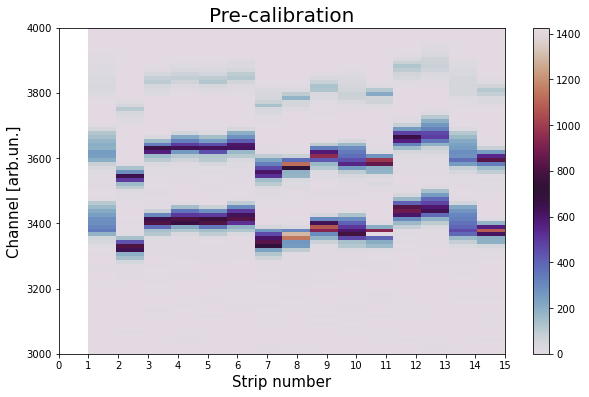

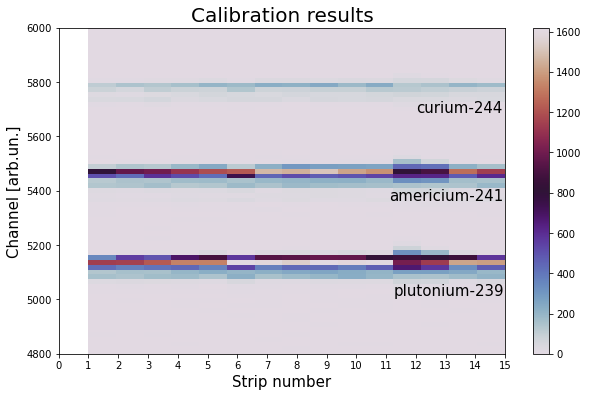

In [22]:

# Showing results of calibration

filename = "20240826_sparechip04_uncalib.txt"
filepath = os.path.join(work_dir, filename)
my_df = pd.read_csv(filepath, sep=" ", header=0) 


position = my_df['Strippos'].to_numpy()
energy = my_df['Energy'].to_numpy()
strip = my_df['Stripnum'].to_numpy()


calib_position = "Calib_position_"+str(chipnumber)+".dat"
pos_path = os.path.join(work_dir, calib_position)
a,b,c = np.loadtxt(pos_path, unpack=True)

calib_energy = "Calib_Energy_"+str(chipnumber)+".dat"
en_path = os.path.join(work_dir, calib_energy)
m,q = np.loadtxt(en_path, unpack=True)

corrected_energy=[]
corrected_strip=[]

uncalib_strip=[]
uncalib_energy=[]

for ii in range(0,16):
        index = my_df['Stripnum'].loc[my_df['Stripnum'] == ii].index
        strip_energy = energy[index]
        strip_position = position[index]
        strip_number = strip[index]
        energy_sel = strip_energy[strip_energy!=0] 
        position_sel = strip_position[strip_energy!=0]
        strip_sel = strip_number[strip_energy!=0]
        uncalib_strip.append(ii)
        uncalib_energy.append(energy_sel)

        for jj in range(len(energy_sel)):

                delta_E = a[ii]*position_sel[jj]**2 + b[ii]*position_sel[jj] + c[ii]
                energy_corr = energy_sel[jj] - delta_E
                energy_fin = m[ii]*energy_corr + q[ii]
                corrected_energy.append(energy_fin)
                corrected_strip.append(ii)

mask = energy!=0

# pre calibration
plt.figure(figsize=(10,6))
plt.hist2d(strip[mask], energy[mask], bins=(15,500), cmap='twilight')
plt.colorbar()
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Strip number', fontsize=15)
plt.ylabel('Channel [arb.un.]', fontsize=15)
plt.title('Pre-calibration', fontsize=20)
plt.ylim(3000,4000)

#calibration result
plt.figure(figsize=(10,6))
ax=plt.gca()
plt.hist2d(corrected_strip, corrected_energy, bins=(15,500), cmap='twilight')
plt.colorbar()
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Strip number', fontsize=15)
plt.ylabel('Channel [arb.un.]', fontsize=15)
plt.title('Calibration results', fontsize=20)
plt.ylim(4800,6000)
plt.text(0.75, 0.18, 'plutonium-239', transform=ax.transAxes, fontsize=15)
plt.text(0.74, 0.47, 'americium-241', transform=ax.transAxes, fontsize=15)
plt.text(0.8, 0.74, 'curium-244', transform=ax.transAxes, fontsize=15)